# Plan-and-Execute

Wir zeigen hier einen typischen Plan-and-Execute Agenten. Er lehnt sich stark am [Plan-and-Solve](https://arxiv.org/abs/2305.04091) Paper und dem [Baby-AGI](https://github.com/yoheinakajima/babyagi) an.

Der Agent plant nicht, wie ein ReAct-Agent immer nur einen Schritt. Vielmehr erstellt er eine komplette TODO-Liste um die Aufgabe zu erledigen.

Nach jedem TODO schaut er, ob er neu planen sollte, weil möglicherweise Zwischenergebnisse nicht wie erwartet ausgefallen sind.

Dieser Typ von Agent ist überaus wirksam wenn viele Einzelschritte benötigt werden. Die Planungsschritte benötigen überlichweise größere LLMs. Der Aufgaben-Worker kann mit schlankeren und günstigeren Modellen kostengünstig fahren.

So ungefähr sieht das aus:


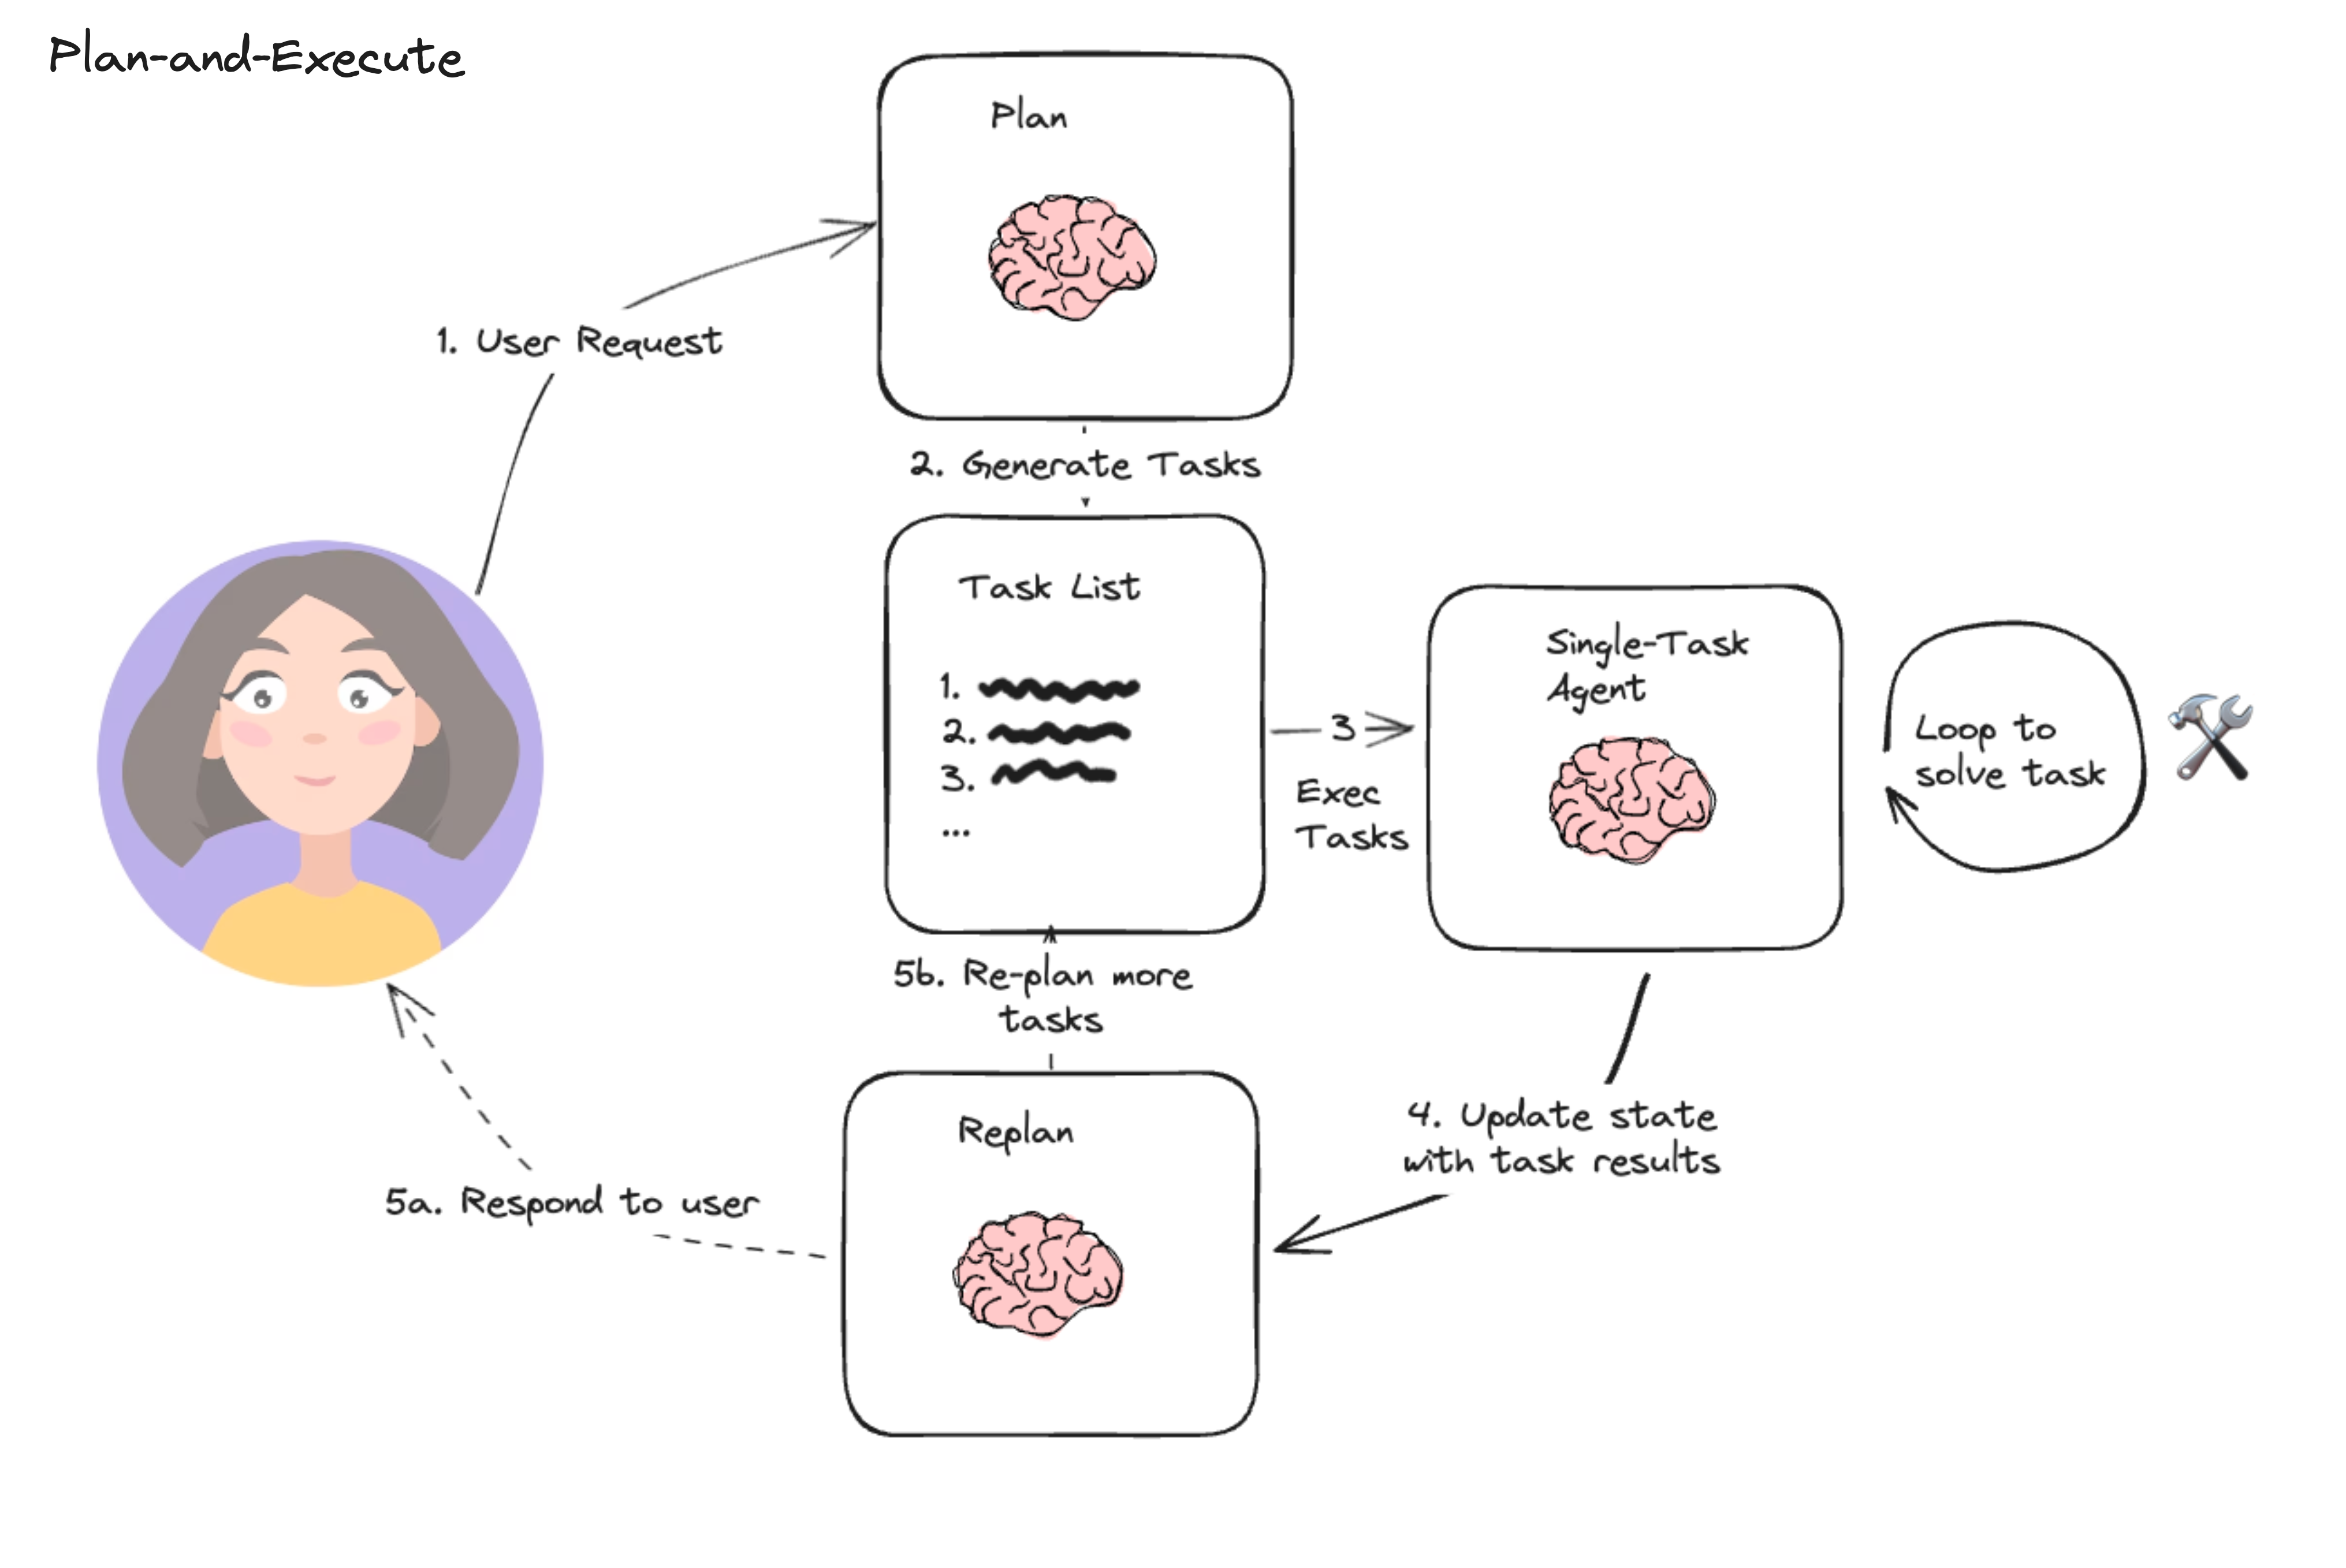


#### Wir fangen wie immer mit dem Agent-State an

Wir brauchen:

- Die Eingabe
- Den Plan
- Was wir vom Plan schon erledigt haben
- Das Ergebnis


In [13]:
from typing import List, Tuple, Annotated, TypedDict
import operator


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

#### Tools

Aus Bequemlichkeit geben wir unserem Agenten einfach mal nur ein Tavily-Search Tool mit.
Einen API-Zugang kann man sich [hier](https://tavily.com) kostenlos holen.


In [2]:
from helpers import llm
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

#### Der Agent, der die die Aufgaben des Planners ausführt


In [3]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage

system_message = SystemMessage(content="You are a helpful assistant.")
agent_executor = create_react_agent(
    llm(model="gpt-4o", temperature=0), tools, state_modifier=system_message
)

#### Der Planner und der Re-Planner

Die Planner sind die Brains. Der Planner gibt immer eine List an Aufgaben zurück.
Der Re-Planner gibt entweder eine List mit Aufgaben zurück oder das Ergbnis, wenn keine weiteren Aufgaben zu erledigen sind.


In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


planner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

{objective}"""
)

planner_llm = llm(model="gpt-4o", temperature=0).with_structured_output(Plan)
planner = planner_prompt | planner_llm

In [5]:
from langchain.output_parsers import PydanticToolsParser


class Response(BaseModel):
    """Response to user."""

    response: str


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = (
    replanner_prompt
    | llm(model="gpt-4o", temperature=0).bind_tools([Plan, Response])
    | PydanticToolsParser(tools=[Plan, Response], first_tool_only=True)
)

#### Alles zusammenbauen


In [16]:
from langchain.schema import HumanMessage
from langgraph.graph import END


async def agent(state: PlanExecute):
    task = state["plan"][0]
    agent_response = await agent_executor.ainvoke(
        {
            "messages": [
                HumanMessage(content=task),
            ]
        }
    )
    return {"past_steps": [(task, agent_response["messages"][-1].content)]}


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"objective": state["input"]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output, Response):
        return {"response": output.response}
    else:
        return {"plan": output.steps}


def should_end(state: PlanExecute):
    if state.get("response", None):
        return END
    else:
        return "agent"

In [17]:
from langgraph.graph import StateGraph

workflow = StateGraph(PlanExecute)
workflow.add_node("planner", plan_step)
workflow.add_node("agent", agent)
workflow.add_node("replan", replan_step)
workflow.set_entry_point("planner")
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")
workflow.add_conditional_edges("replan", should_end)
app = workflow.compile()

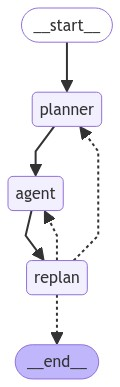

In [18]:
from IPython.display import Image

display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the winner of the 2024 Australian Open.', 'Research the hometown of the identified winner.']}
{'past_steps': [('Identify the winner of the 2024 Australian Open.', "The winner of the 2024 Australian Open men's singles title is Jannik Sinner. He achieved his first Grand Slam title by defeating Daniil Medvedev in a five-set match with scores of 3-6, 3-6, 6-4, 6-4, 6-3.")]}
{'plan': ['Research the hometown of Jannik Sinner.']}
{'past_steps': [('Research the hometown of Jannik Sinner.', "Jannik Sinner's hometown is Sexten (also known as Sesto) in northern Italy. It is located in the Dolomites region of South Tyrol. Sinner has expressed that returning to his hometown is always a special and emotional experience for him.")]}
{'response': 'The hometown of the 2024 Australian Open winner, Jannik Sinner, is Sexten (also known as Sesto) in northern Italy.'}


In [21]:
config = {"recursion_limit": 50}
inputs = {"input": "Wie hoch ist der Altersunterschied zwischen Dieter Bohlen und seiner Frau in Tagen?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Finde das Geburtsdatum von Dieter Bohlen.', 'Finde das Geburtsdatum von Dieter Bohlens Frau.', 'Berechne das Alter von Dieter Bohlen in Tagen ab seinem Geburtsdatum bis zum heutigen Datum.', 'Berechne das Alter von Dieter Bohlens Frau in Tagen ab ihrem Geburtsdatum bis zum heutigen Datum.', 'Subtrahiere das Alter von Dieter Bohlens Frau in Tagen vom Alter von Dieter Bohlen in Tagen, um den Altersunterschied in Tagen zu erhalten.']}
{'past_steps': [('Finde das Geburtsdatum von Dieter Bohlen.', 'Dieter Bohlen wurde am 7. Februar 1954 geboren.')]}
{'plan': ['Finde das Geburtsdatum von Dieter Bohlens Frau.', 'Berechne das Alter von Dieter Bohlen in Tagen ab seinem Geburtsdatum bis zum heutigen Datum.', 'Berechne das Alter von Dieter Bohlens Frau in Tagen ab ihrem Geburtsdatum bis zum heutigen Datum.', 'Subtrahiere das Alter von Dieter Bohlens Frau in Tagen vom Alter von Dieter Bohlen in Tagen, um den Altersunterschied in Tagen zu erhalten.']}
{'past_steps': [('Finde das Geburtsd

#### Langsam?

Eine Schwachstelle dieser Architektur ist die sequenzielle Abarbeitung der Schritte. Der [LLM-Compiler](https://github.com/langchain-ai/langgraph/blob/main/examples/llm-compiler/LLMCompiler.ipynb) z.B. erstellt keine Aufgabenliste sondern einen Aufgaben-DAG (Directed Acyclic Graph) und kann parallel arbeiten.


## ✅ Aufgabe

#### Recursion Limit

Setzt das Recursion Limit auf einen sehr kleinen Wert. Wofür könnte das nützlich sein?


In [20]:
# low_recursion_config =
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in app.astream(inputs, config=low_recursion_config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

NameError: name 'low_recursion_config' is not defined

#### Subgraph

In dieser Applikation ist ein Subgraph eingebaut.

- Hat er einen eigenen State?
- Muss ein Subgraph immer einen eigenen State haben?
